In [112]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import re
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter
import sklearn.tree as tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score
import plotly.express as px
from scipy import stats

In [2]:
#Read the session data set to a dataframe
session_data = pd.read_csv('seasonal.csv',low_memory = False)
pd.options.display.max_columns = None

In [3]:
#1st 5 records
session_data.head()

visitorid  visitordate visitormonth  visitoryear  \
0  2DEGHH81B2-4H79-J2G7            6          Aug         2013   
1  2DB42B0569-H5HD-JJBF           13          Jun         2013   
2  2D61CGGJ2C-2F86-43G9            6          Sep         2013   
3  2E19765EF7-AG57-5J72           12          Nov         2013   
4  2DDD5IH5G2-IH15-5I3J           19          Jul         2013   

  visitorstartdayname visitorstarthour  visitorduration  visitorsession  \
0                 Sun         10:59:43               13               1   
1                 Sun         10:22:40               39               1   
2                 Sun         19:05:23                2               2   
3                 Sat         13:03:23               49               1   
4                 Sat         23:30:07              484               1   

      brand devicetype  eventcountpt  eventcountlc   trafficsource  \
0  Chrysler     Mobile             1             4  Other Referral   
1  Chrysler   Computer             4             3     Paid Search   
2  Chrysler   Computer             2             2          Direct   
3  Chrysler   Computer             4             4          Direct   
4  Chrysler   Computer            12            10     Paid Search   

  campaignsiteid campaignbuyid campaignadvertisementid campaignplacementid  \
0            NaN           NaN                     NaN                 NaN   
1        1037056           NaN                     NaN                 NaN   
2            NaN           NaN                     NaN                 NaN   
3            NaN           NaN                     NaN                 NaN   
4            NaN           NaN                     NaN                 NaN   

  campaigncreativeid campaignpskeyword  searchenginekeyword  vehicle200pt  \
0                NaN               NaN                  NaN             0   
1                NaN      chrysler 300                  NaN             0   
2                NaN               NaN                  NaN             0   
3                NaN               NaN                  NaN             0   
4                NaN          chrysler                  NaN             3   

   vehicle200lc  vehicle200convertiblept  vehicle200convertiblelc  \
0             0                        0                        0   
1             0                        0                        0   
2             0                        0                        0   
3             0                        4                        4   
4             2                        0                        0   

   vehicle300pt  vehicle300lc  vehicletowncountrypt  vehicletowncountrylc  \
0             0             0                     0                     0   
1             4             3                     0                     0   
2             0             0                     0                     0   
3             0             0                     0                     0   
4             3             2                     2                     3   

   vsclanding  vscmodels  vscgallery  vscexterior  vscinterior  \
0           0          0           0            0            0   
1           1          0           0            0            0   
2           0          0           0            0            0   
3           0          0           0            0            0   
4           2          0           0            0            0   

   vscperformance  vscsafety  vscawards  vscspecifications  \
0               0          0          0                  0   
1               0          0          0                  0   
2               0          0          0                  0   
3               0          0          0                  0   
4               0          0          0                  0   

   vscmodelhighlights  vscdimensions  vscwarranty  msplanding  mspgallery  \
0                   0              0            0           0           0   
1          

In [4]:
#Count NA values in devicetype
session_data['devicetype'].isnull().sum()

7697

In [5]:
#Drop rows with NA values
session_data.dropna(subset=['devicetype'],inplace=True)

In [6]:
#Drop column searchenginekeyword as there are no values
session_data.drop(labels='searchenginekeyword', axis=1, inplace=True)

In [7]:
#Drop columns that have only zero values - those are not signifcant
zero_columns=[col for col,is_zero in ((session_data == 0).sum() == session_data.shape[0]).items() if is_zero]
print("Zero value columns :",zero_columns)
session_data.drop(zero_columns,axis=1,inplace=True)

Zero value columns : ['stbrochuresubmitted']


**Categorical variable analysis**

In [8]:
#To check if there are multiple visitors or not
session_data['visitorid'].value_counts()

2DCJB0JH5E-0966-638F    54
2DFGJ16EC3-D3C4-68HH    47
2E1D5H59A4-6CF9-C28A    39
2D9E82D837-F001-I9JG    36
2BGCD6J269-J4A6-3FAH    34
                        ..
2DAADEBEA2-2CFF-A2I2     1
2E1513720J-GJFF-C955     1
2DDJH0IJ6E-30D2-DJ3C     1
2E44B9JGD5-IHBE-691D     1
2DB56BG34G-HDHD-3H22     1
Name: visitorid, Length: 455040, dtype: int64

In [9]:
session_data['trafficsource'].value_counts()

Direct              149902
Paid Search         105965
Natural Search      101393
Display              52905
Other Referral       21624
LLC Group            13617
Paid Search & Na      7443
Natural Search &      7236
Email                 2896
Direct & Paid Se      2740
Direct & Natural      2580
Direct & Other R      1041
Other Referral &       845
Paid Search & Ot       742
Direct & Display       717
Paid Search & LL       627
Direct & LLC Gro       607
Social                 511
Display & Other        509
Paid Search & Di       509
Display & Paid S       333
Display & LLC Gr       299
Display & Natura       194
LLC Group & Othe       166
LLC Group & Paid        76
Email & LLC Grou        64
LLC Group & Natu        56
Direct & Email          44
Direct & Social         40
Paid Search & So        23
Display & Social        17
Email & Other Re        14
Social & Natural        12
Email & Natural         12
LLC Group & Disp        11
Email & Display          8
LLC Group & Soci         6
E

**Merge trafic sources to primary groups**

In [10]:
def traffic_pattern(x):
 
    if(re.findall("^Direct",x)):
        return 'Direct'
    elif(re.findall("^Paid Search",x)):
        return 'Paid Search'
    elif(re.findall("^Natural Search",x)):
        return 'Natural Search'
    elif(re.findall("^Display",x)):
        return 'Display'
    elif(re.findall("^Other Referral",x)):
        return 'Other Referral'
    elif(re.findall("^LLC Group",x)):
        return 'LLC Group'
    elif(re.findall("^Email",x)):
        return 'Email'
    elif(re.findall("^Social",x)):
        return 'Social'
    
session_data['trafficsource']=session_data['trafficsource'].apply(lambda x:traffic_pattern(x))

In [11]:
#Drop 'campaignsearchkeyword' 
session_data.drop(axis=1, labels='campaignpskeyword', inplace=True)

In [12]:
#Combine campaign related columns to a single column.
session_data['campaign'] = session_data.loc[:,"campaignsiteid":"campaigncreativeid"].notnull().sum(axis=1)
session_data.drop(['campaignsiteid','campaignbuyid','campaignadvertisementid','campaignplacementid','campaigncreativeid'],axis=1,inplace= True)

In [13]:
#Categorize campaign
def categorize(x):
    if (x!=0):
        return 1
    else:
        return 0
session_data['campaign'] = session_data['campaign'].apply(lambda x:categorize(x))
session_data['bmo'] = session_data['stbmovehicleselector'].apply(lambda x:categorize(x))
session_data['payment'] = session_data['stpaymentresults'].apply(lambda x:categorize(x))

In [14]:
#Categorize bmo and add new column
def bmo(x):
    if (x!=0):
        return 1
    else:
        return 0
session_data['bmo'] = session_data['stbmovehicleselector'].apply(lambda x:bmo(x))

In [15]:
#Categorize payment and add new column
def payment(x):
    if (x!=0):
        return 1
    else:
        return 0
session_data['payment'] = session_data['stpaymentresults'].apply(lambda x:payment(x))

### Univariate Analysis

**Device Type Vs visitors**

**Most of the visitors to the Crysler site use Computer**

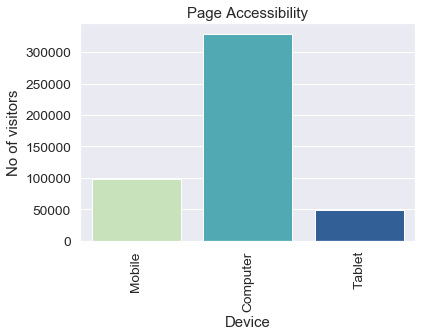

In [16]:
sns.set(font_scale= 1.25)
sns.countplot(x='devicetype',data=session_data,palette='YlGnBu')
sns.set_style('ticks')
plt.title("Page Accessibility")
plt.xlabel("Device")
plt.ylabel("No of visitors")
plt.xticks(rotation=90)
plt.show()

**Traffic Source Vs Visitors**

**The top 3 traffic sources are Direct, Paid Search and Natural Search**

**We can see that Crysler website is not getting much visitors from 'Email' and 'Social Media' sources. These channels have potential to get more visitors to the marketing funnel.**

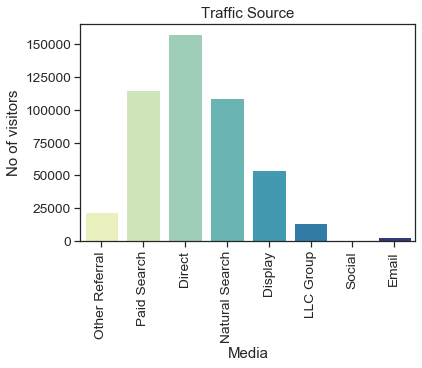

In [17]:
sns.countplot(x='trafficsource',data=session_data,palette='YlGnBu')
plt.title("Traffic Source")
plt.xlabel("Media")
plt.ylabel("No of visitors")
plt.xticks(rotation=90)
plt.show()

**Days Vs Visitors**

**There is no significant difference, but people generally prefer to browse the site on the weekdays rather than on weekends**

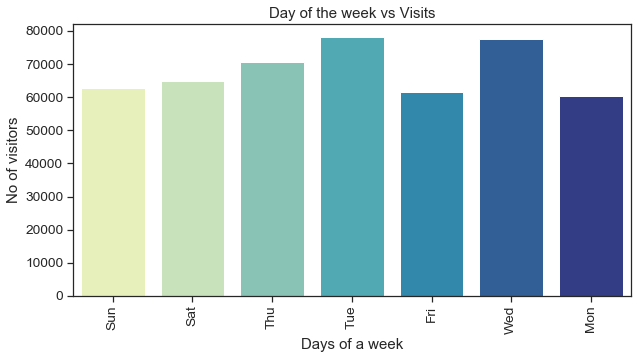

In [18]:
plt.figure(figsize=(10,5))
sns.countplot(x='visitorstartdayname',data=session_data,palette='YlGnBu')
plt.title("Day of the week vs Visits")
plt.xlabel("Days of a week")
plt.ylabel("No of visitors")
plt.xticks(rotation=90)
plt.show()

**Months Vs Visitors**

**The number of visitors gradually decreasing during the time span of June to December.**
**However in the month of October, due to some reason, there were no visitors visitng the site**

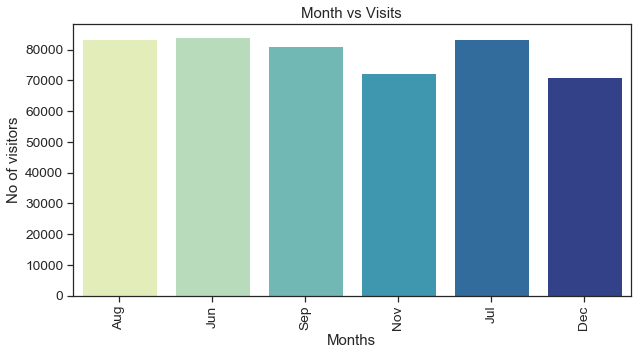

In [19]:
plt.figure(figsize=(10,5))
sns.countplot(x='visitormonth',data=session_data,palette='YlGnBu')
plt.title("Month vs Visits")
plt.xlabel("Months")
plt.ylabel("No of visitors")
plt.xticks(rotation=90)
plt.show()

### Multivariate Analysis

#### Analysis of impact of campaingn:
**People from Paid seraches and Display media are mostly part of campains. However, visitors from Direct and Natural searches are generally not part of campains.**

**But if payment and BMO are considered, visitors from Direct channel tend to visit payment page more.**

**This shows that people taking part in the campaings are not getting converted**

**The campaigns can be published on Email and Social media, which can help Crysler to get more visitors to the site and this will also result to more conversions.**

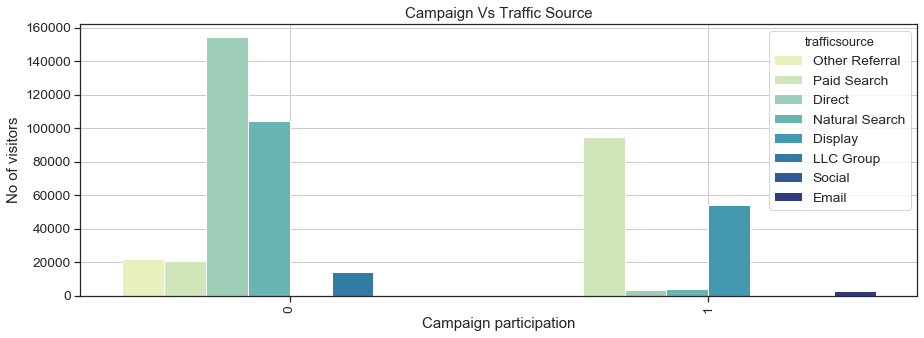

In [20]:

plt.figure(figsize=(15,5))
sns.countplot(x='campaign',data=session_data,hue='trafficsource',palette='YlGnBu')
plt.title("Campaign Vs Traffic Source")
plt.xlabel("Campaign participation")
plt.ylabel("No of visitors")
plt.xticks(rotation=90)
plt.grid()
plt.show()

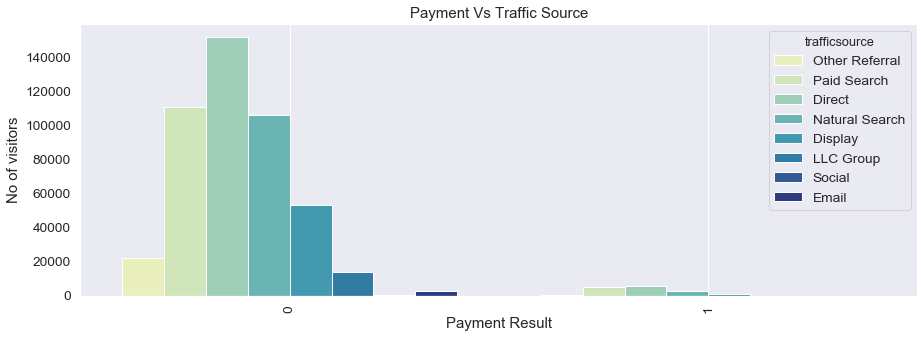

In [21]:
#No. of visitors from different traffic sources visiting BMO page.
plt.figure(figsize=(15,5))
sns.set(font_scale= 1.25)
sns.countplot(x='payment',data=session_data,hue='trafficsource',palette = 'YlGnBu')
plt.title("Payment Vs Traffic Source")
plt.xlabel("Payment Result")
plt.ylabel("No of visitors")
plt.xticks(rotation=90)
plt.grid()
plt.show()

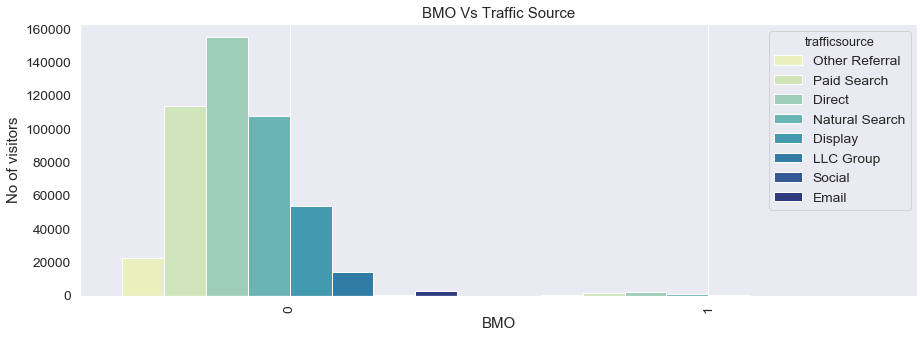

In [22]:
#No. of visitors from different traffic sources visiting BMO page.
plt.figure(figsize=(15,5))
sns.countplot(x='bmo',data=session_data,hue='trafficsource',palette='YlGnBu')
plt.title("BMO Vs Traffic Source")
plt.xlabel("BMO")
plt.ylabel("No of visitors")
plt.xticks(rotation=90)
plt.grid()
#plt.figure(figsize=(200,500))
plt.show()

### Vehicle model pages Vs HVA:

**Any specific car model is not attacting visiors to BMO page or Payment page**

**The search pattern is same for visitors irrespective of them visiting the Payment result page.**

**One thing we can conclude is irrespective of payment results, Vehicle 300, Vehicle Town Country are the top two browsed car models**

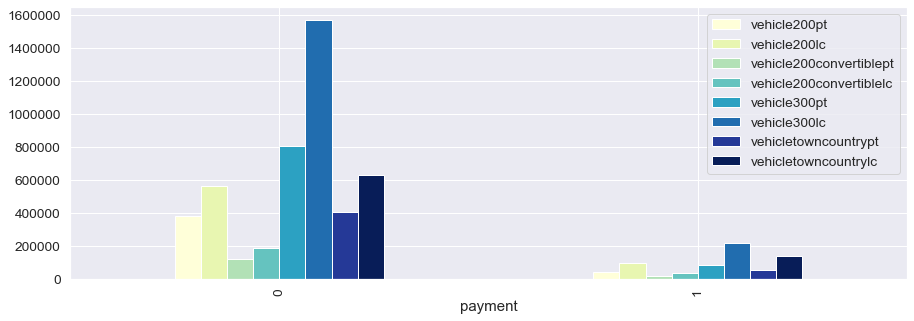

In [23]:
session_data[["vehicle200pt", "vehicle200lc", "vehicle200convertiblept", "vehicle200convertiblelc","vehicle300pt","vehicle300lc","vehicletowncountrypt","vehicletowncountrylc"]].groupby(session_data['payment']).sum().plot(kind = 'bar',figsize=(15,5), colormap='YlGnBu')

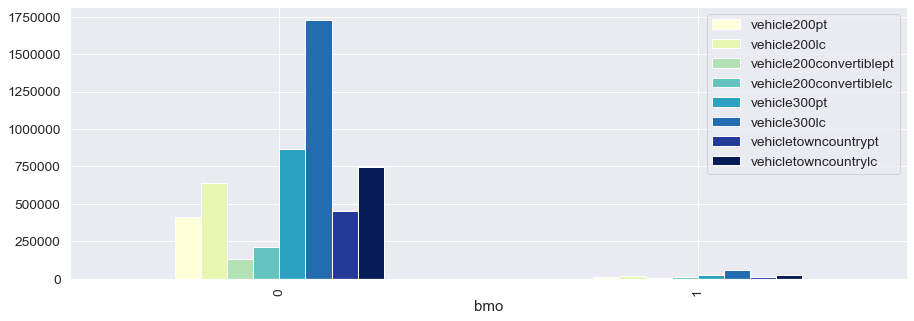

In [24]:
session_data[["vehicle200pt", "vehicle200lc", "vehicle200convertiblept", "vehicle200convertiblelc","vehicle300pt","vehicle300lc","vehicletowncountrypt","vehicletowncountrylc"]].groupby(session_data['bmo']).sum().plot(kind = 'bar',figsize=(15,5), colormap='YlGnBu');

## NOTE: Need to discuss IQR based 

(array([-20000.,      0.,  20000.,  40000.,  60000.,  80000., 100000.]),
 <a list of 7 Text xticklabel objects>)

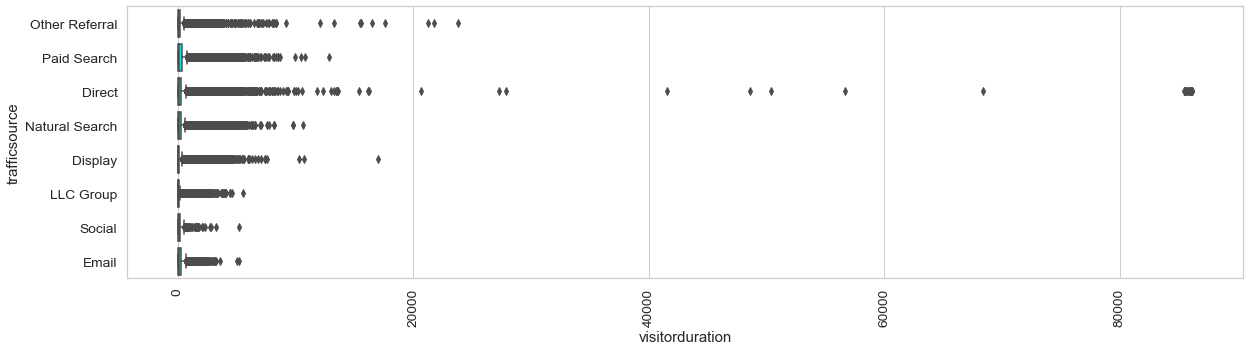

In [25]:
#visitorduration max value=86143, need to check the outliers in details
sns.set_style('whitegrid')
plt.figure(figsize=(20,5))
box_plot = sns.boxplot(data=session_data, x='visitorduration', y = 'trafficsource', color='cyan')
plt.xticks(rotation=90)

**No Visitors browsing more than 12000 secs are going to BMO or Payment page**

In [26]:
session_data.query("visitorduration > 12000").query("payment ==1")

Empty DataFrame
Columns: [visitorid, visitordate, visitormonth, visitoryear, visitorstartdayname, visitorstarthour, visitorduration, visitorsession, brand, devicetype, eventcountpt, eventcountlc, trafficsource, vehicle200pt, vehicle200lc, vehicle200convertiblept, vehicle200convertiblelc, vehicle300pt, vehicle300lc, vehicletowncountrypt, vehicletowncountrylc, vsclanding, vscmodels, vscgallery, vscexterior, vscinterior, vscperformance, vscsafety, vscawards, vscspecifications, vscmodelhighlights, vscdimensions, vscwarranty, msplanding, mspgallery, mspexterior, mspinterior, mspperformance, mspsafety, stbmovehicleselector, stmodels, stcolors, stoptions, stsummaries, stenterzip, stenterzipresult, stdlhours, stdlservices, stdldealersites, stsnivehicleselector, stsnivehicleselectorresult, stsnivin, stsnidetails, stsnidealers, sttestdriveform, sttestdrivecomplete, stincentivesbrand, stincentivesvehicle, stprecalc, stpaymentresults, stgaqform, stgaqsubmitted, stbrochuremailform, stbrochuredownloadform, stsignupforupdatesform, stsignupforupdatessubmit, stmodelcompareindex, stmodelcomparemodelbymodel, stmodelcomparequickchart, stmodelcomparegraphsnumbers, stmodelcomparedetailedchart, campaign, bmo, payment]
Index: []

In [27]:
#Remove all records with visitor duration more than 12000
session_data=session_data[session_data.visitorduration <= 12000]

In [116]:
#n1=len(session_data.query("devicetype == 'Computer'"))
#p1 = len(session_data.query("devicetype == 'Computer'").query("stbmovehicleselector != 0"))/n1
#print("n1 = ",n1)
#print("p1 = ",p1)

#n2=len(session_data.query("devicetype != 'Computer'"))
#p2 = len(session_data.query("devicetype != 'Computer'").query("stbmovehicleselector != 0"))/n2
#print("n2 = ",n2)
#print("p2 = ",p2)

In [117]:
#Create populations
#population1 = np.random.binomial(1,p1,n1)
#population2 = np.random.binomial(1,p2,n2)

In [118]:
#sm.stats.ttest_ind(population1,population2)

**Chi Square Test of independence**\

**Null Hypothesis = Device does not have any dependency on BMO page**\
**Alternate Hypothesis = Device makes a difference**

|       |Computer|Mobile|Tablet|
|-------|--------|------|------|
|BMO    |1933    |2955  |382   |
|Non BMO|326841  |94641 |48953 |

====Chi2_stat====\
4145.040204719361


====P_value====\
0.0


====Degrees of freedom====\
2

**Conclusion: Device and BMO are not independent.**


In [104]:
print("BMO + Computer: ", len(session_data.query("devicetype == 'Computer'").query("stbmovehicleselector != 0")))
print("BMO + Mobile: ", len(session_data.query("devicetype == 'Mobile'").query("stbmovehicleselector != 0")))
print("BMO + Tablet: ", len(session_data.query("devicetype == 'Tablet'").query("stbmovehicleselector != 0")))

BMO + Computer:  1933
BMO + Mobile:  2955
BMO + Tablet:  382


In [106]:
print("Non BMO + Computer: ", len(session_data.query("devicetype == 'Computer'").query("stbmovehicleselector == 0")))
print("Non BMO + Mobile: ", len(session_data.query("devicetype == 'Mobile'").query("stbmovehicleselector == 0")))
print("Non BMO + Tablet: ", len(session_data.query("devicetype == 'Tablet'").query("stbmovehicleselector == 0")))

Non BMO + Computer:  326841
Non BMO + Mobile:  94641
Non BMO + Tablet:  48953


In [110]:
data = {'Computer':[1933,326841],'Mobile':[2955,94641],'Tablet':[382,48953]}
df3=pd.DataFrame(data,index=['BMO','Non BMO'])
df3

Computer  Mobile  Tablet
BMO          1933    2955     382
Non BMO    326841   94641   48953

In [115]:
chi2_stat,p_val,DOF,ex = stats.chi2_contingency(df3)
print("====Chi2_stat====")
print(chi2_stat)
print("\n")

print("====P_value====")
print(p_val)
print("\n")

print("====Degrees of freedom====")
print(DOF)
print("\n")

print("====Contingency table====")
print(ex)
print("\n")

====Chi2_stat====
4145.040204719361


====P_value====
0.0


====Degrees of freedom====
2


====Contingency table====
[[  3642.25513711   1081.19721256    546.54765033]
 [325131.74486289  96514.80278744  48788.45234967]]




#### Hypothesis : Does a visitor visiting the BMO page has a higher browsing duration than the ones who dont visit the BMO page?
##### Parameter of interest: visitor duration
**Null Hypothesis :** $\mu_1=\mu_2$ (There is **no** difference between the average visitor durations in both the population)

**Alternate Hypothesis:** $\mu_1\neq \mu_2$ (There is difference between the average visitor durations in both the population)

**Mean Duration for BMO =  591.15\
Mean Duration for non BMO =  267.22**

**Reject the null hypothesis as the population means are different.**

**Conclusion: Visitors who visit BMO page are spending much time in the session**

In [31]:
#Average time spent on browsing the site
session_data.loc[:,'visitorduration'].mean()

270.81348524821055

In [32]:
time_bmo=session_data.query("stbmovehicleselector != 0")
mean_bmo = time_bmo.loc[:,'visitorduration'].mean()
print("Mean Duration for BMO = ",mean_bmo)

time_non_bmo = session_data.query("stbmovehicleselector == 0")
mean_non_bmo = time_non_bmo.loc[:,'visitorduration'].mean()
print("Mean Duration for non BMO = ",mean_non_bmo)

Mean Duration for BMO =  591.1500948766603
Mean Duration for non BMO =  267.22494712340705


In [33]:
sm.stats.ztest(time_bmo['visitorduration'],time_non_bmo['visitorduration'],alternative='larger')

(47.27367350318888, 0.0)

##### Impact of Device on visitors visiting BMO and Payment pages

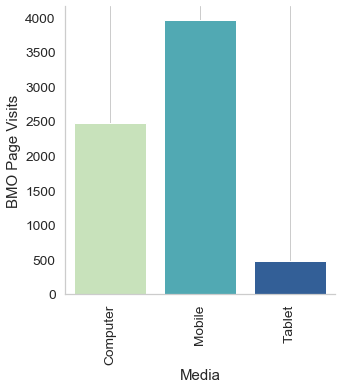

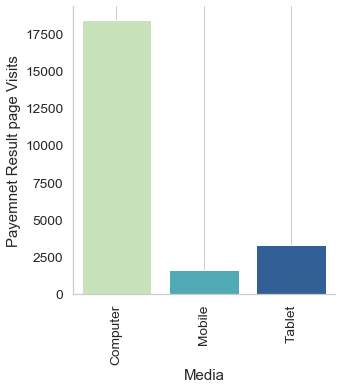

In [34]:
sns.catplot(x="devicetype",y="stbmovehicleselector",kind="bar",palette='YlGnBu',data=(session_data.groupby('devicetype',as_index=False).agg({'stbmovehicleselector':np.sum})))
plt.xlabel("Media")
plt.ylabel("BMO Page Visits")
plt.xticks(rotation=90)
plt.grid()
plt.show()

sns.catplot(x="devicetype",y="stpaymentresults",kind="bar",palette='YlGnBu',data =(session_data.groupby('devicetype',as_index=False).agg({'stpaymentresults':np.sum})))
plt.xlabel("Media")
plt.ylabel("Payemnet Result page Visits")
plt.xticks(rotation=90)
plt.grid()
plt.show()

#### Traffic source:
##### Hypothesis: Traffic source does not have impact on likelihood of visitors visiting the HVA pages.

##### The traffic sources 'Paid Search', 'Direct' and 'Natural Search' are the top 3 contributors for HVA like BMO, Payment results.
##### Based on the data also we found that these are the top sources for visitors irrespective of visitors visiting the HVA pages.
##### So, traffic sources does not have any impact likelihood.

##### However, other traffic sources like Social and Email which are now a days being used by everyone and not able to contibute in getting the visitors to the HVA pages. Chrysler should aim to get more visitors from email and social sorces.

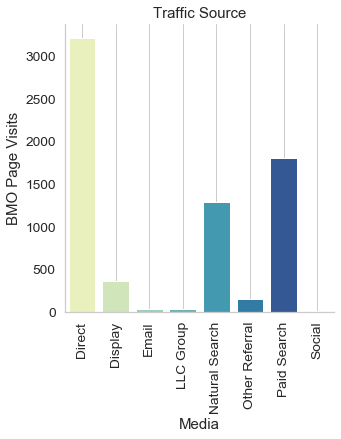

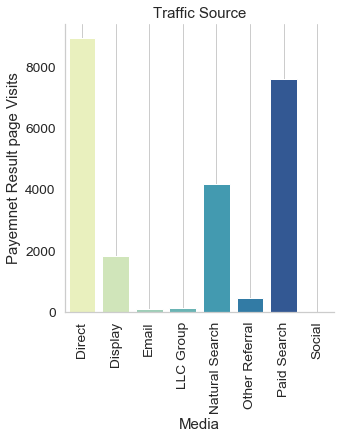

In [35]:
sns.catplot(x="trafficsource",y="stbmovehicleselector",kind="bar",palette='YlGnBu',data=(session_data.groupby('trafficsource',as_index=False).agg({'stbmovehicleselector':np.sum})))
plt.title("Traffic Source")
plt.xlabel("Media")
plt.ylabel("BMO Page Visits")
plt.xticks(rotation=90)
plt.grid()
plt.show()

sns.catplot(x="trafficsource",y="stpaymentresults",kind="bar",palette='YlGnBu',data =(session_data.groupby('trafficsource',as_index=False).agg({'stpaymentresults':np.sum})))
plt.title("Traffic Source")
plt.xlabel("Media")
plt.ylabel("Payemnet Result page Visits")
plt.xticks(rotation=90)
plt.grid()
plt.show()

#### In the month of Nov and Dec, almost no one visited the BMO page.

Text(0, 0.5, 'Number of times Payment vs BMO page hit ')

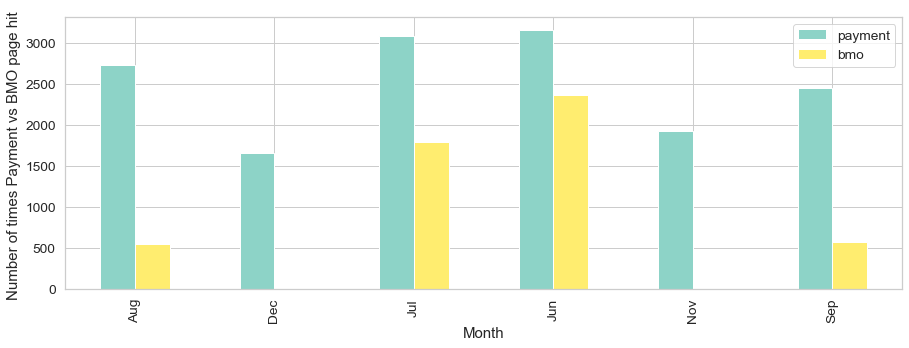

In [36]:
#Months Vs Visits to BMO and Payment page
session_data.groupby(by=['visitormonth'])['payment', 'bmo'].sum().plot.bar(figsize=(15,5),colormap='Set3')
plt.xlabel("Month")
plt.ylabel("Number of times Payment vs BMO page hit ")

#### KDE plots to understand the probalibility distribution:

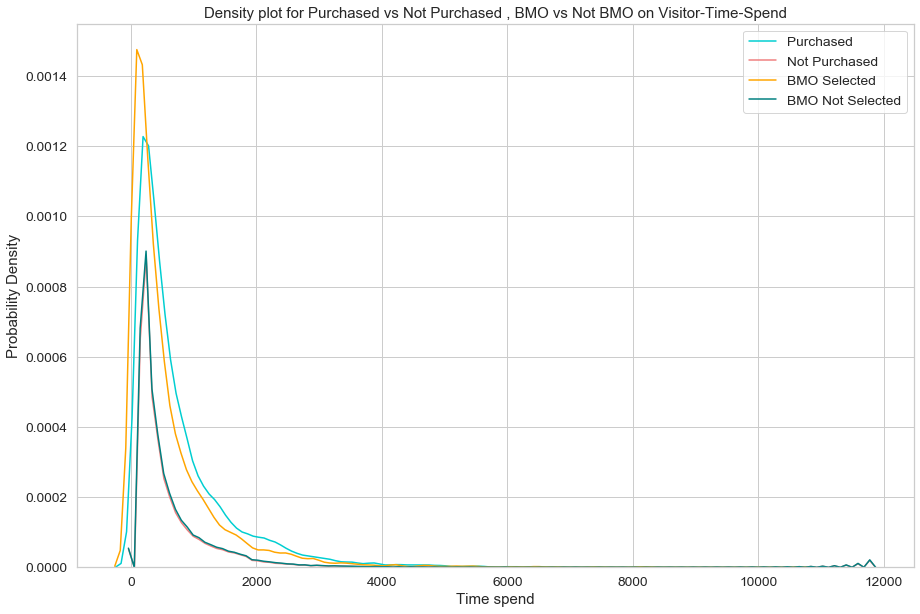

In [37]:
sns.set_style('whitegrid')
plt.figure(figsize=(15,10))
ax = sns.kdeplot(session_data['visitorduration'][session_data.stpaymentresults >0], color='darkturquoise')
sns.kdeplot(session_data['visitorduration'][session_data.stpaymentresults == 0], color='lightcoral')
sns.kdeplot(session_data['visitorduration'][session_data.bmo > 0], color='orange')
sns.kdeplot(session_data['visitorduration'][session_data.bmo == 0], color='teal')
plt.legend(['Purchased','Not Purchased','BMO Selected', 'BMO Not Selected'])
plt.title('Density plot for Purchased vs Not Purchased , BMO vs Not BMO on Visitor-Time-Spend')
ax.set(xlabel='Time spend')
ax.set(ylabel='Probability Density')
plt.show()

**Single Vs Multi-visit analysis**

In [38]:
sitevisit_seasonal_DF = session_data

In [39]:
sitevisit_seasonal_DF.head()

visitorid  visitordate visitormonth  visitoryear  \
0  2DEGHH81B2-4H79-J2G7            6          Aug         2013   
1  2DB42B0569-H5HD-JJBF           13          Jun         2013   
2  2D61CGGJ2C-2F86-43G9            6          Sep         2013   
3  2E19765EF7-AG57-5J72           12          Nov         2013   
4  2DDD5IH5G2-IH15-5I3J           19          Jul         2013   

  visitorstartdayname visitorstarthour  visitorduration  visitorsession  \
0                 Sun         10:59:43               13               1   
1                 Sun         10:22:40               39               1   
2                 Sun         19:05:23                2               2   
3                 Sat         13:03:23               49               1   
4                 Sat         23:30:07              484               1   

      brand devicetype  eventcountpt  eventcountlc   trafficsource  \
0  Chrysler     Mobile             1             4  Other Referral   
1  Chrysler   Computer             4             3     Paid Search   
2  Chrysler   Computer             2             2          Direct   
3  Chrysler   Computer             4             4          Direct   
4  Chrysler   Computer            12            10     Paid Search   

   vehicle200pt  vehicle200lc  vehicle200convertiblept  \
0             0             0                        0   
1             0             0                        0   
2             0             0                        0   
3             0             0                        4   
4             3             2                        0   

   vehicle200convertiblelc  vehicle300pt  vehicle300lc  vehicletowncountrypt  \
0                        0             0             0                     0   
1                        0             4             3                     0   
2                        0             0             0                     0   
3                        4             0             0                     0   
4                        0             3             2                     2   

   vehicletowncountrylc  vsclanding  vscmodels  vscgallery  vscexterior  \
0                     0           0          0           0            0   
1                     0           1          0           0            0   
2                     0           0          0           0            0   
3                     0           0          0           0            0   
4                     3           2          0           0            0   

   vscinterior  vscperformance  vscsafety  vscawards  vscspecifications  \
0            0               0          0          0                  0   
1            0               0          0          0                  0   
2            0               0          0          0                  0   
3            0               0          0          0                  0   
4            0               0          0          0                  0   

   vscmodelhighlights  vscdimensions  vscwarranty  msplanding  mspgallery  \
0                   0              0            0           0           0   
1                   0              0            0           2           0   
2                   0              0            0           0           0   
3                   0              0            0           0           0   
4                   0              0            0           2           0   

   mspexterior  mspinterior  mspperformance  mspsafety  stbmovehicleselector  \
0            0            0               0          0                     0   
1            0            0               0          0                     0   
2            0            0               0          0                     0   
3            0            0               0          0                     0   
4            0            0               0          0                     0   

   stmodels  stcolors  stoptions  stsummaries  stenterzip  stenterzip

In [40]:
#generate datefield mm/dd/yyyy
sitevisit_seasonal_DF['VisitDateTime'] = sitevisit_seasonal_DF['visitordate'].apply(str)+'/'+sitevisit_seasonal_DF['visitormonth']+'/'+sitevisit_seasonal_DF['visitoryear'].apply(str);
sitevisit_seasonal_DF['VisitDateTime'] = pd.to_datetime(sitevisit_seasonal_DF['VisitDateTime'])

In [41]:
#Sorting the DF
sitevisit_seasonal_DF = sitevisit_seasonal_DF.sort_values(['VisitDateTime'], ascending=True)
sitevisit_seasonal_DF['VisitDateTime']

15011    2013-06-01
373455   2013-06-01
204648   2013-06-01
122871   2013-06-01
259042   2013-06-01
            ...    
259745   2013-12-31
318494   2013-12-31
318496   2013-12-31
192289   2013-12-31
422530   2013-12-31
Name: VisitDateTime, Length: 475705, dtype: datetime64[ns]

In [42]:
sitevisit_seasonal_DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 475705 entries, 15011 to 422530
Data columns (total 75 columns):
visitorid                      475705 non-null object
visitordate                    475705 non-null int64
visitormonth                   475705 non-null object
visitoryear                    475705 non-null int64
visitorstartdayname            475705 non-null object
visitorstarthour               475705 non-null object
visitorduration                475705 non-null int64
visitorsession                 475705 non-null int64
brand                          475705 non-null object
devicetype                     475705 non-null object
eventcountpt                   475705 non-null int64
eventcountlc                   475705 non-null int64
trafficsource                  475705 non-null object
vehicle200pt                   475705 non-null int64
vehicle200lc                   475705 non-null int64
vehicle200convertiblept        475705 non-null int64
vehicle200convertiblelc       

In [43]:
#One time vs multitime visitor data preparation
user_visit_count_df= sitevisit_seasonal_DF.groupby(by=['visitorid']) ['visitorid'].agg(['count']).sort_values(by='count')

In [44]:
#Join master df with count list
new_sitevisit_DF = pd.merge(sitevisit_seasonal_DF, user_visit_count_df, how='outer', on='visitorid')

In [45]:
new_sitevisit_DF.head()

visitorid  visitordate visitormonth  visitoryear  \
0  2D47EGE6AB-6A24-BJ2A            1          Jun         2013   
1  2D47EGE6AB-6A24-BJ2A            1          Jun         2013   
2  2DA8277GHG-GHB0-HI88            1          Jun         2013   
3  2DA88JF0FC-5DJI-51BD            1          Jun         2013   
4  2DA8695DGA-A7ID-B1AF            1          Jun         2013   

  visitorstartdayname visitorstarthour  visitorduration  visitorsession  \
0                 Tue         19:40:50              920               2   
1                 Tue         15:12:39             1670               1   
2                 Tue         13:46:24               13               1   
3                 Tue         19:39:24               38               1   
4                 Tue         17:24:55              795               1   

      brand devicetype  eventcountpt  eventcountlc trafficsource  \
0  Chrysler   Computer             2           145   Paid Search   
1  Chrysler   Computer            12            40        Direct   
2  Chrysler   Computer             4             2   Paid Search   
3  Chrysler   Computer             2             1        Direct   
4  Chrysler   Computer             2             0        Direct   

   vehicle200pt  vehicle200lc  vehicle200convertiblept  \
0             0             0                        0   
1             0             0                        0   
2             4             2                        0   
3             0             0                        0   
4             2             0                        0   

   vehicle200convertiblelc  vehicle300pt  vehicle300lc  vehicletowncountrypt  \
0                        0             0             0                     0   
1                        0             0             0                    10   
2                        0             0             0                     0   
3                        0             1             0                     0   
4                        0             0             0                     0   

   vehicletowncountrylc  vsclanding  vscmodels  vscgallery  vscexterior  \
0                     0           0          0           0            0   
1                    38           0          0           0            0   
2                     0           0          0           0            0   
3                     0           0          1           0            0   
4                     0           0          2           0            0   

   vscinterior  vscperformance  vscsafety  vscawards  vscspecifications  \
0            0               0          0          0                  0   
1            0               0          0          0                  0   
2            0               0          0          0                  0   
3            0               0          0          0                  0   
4            0               0          0          0                  0   

   vscmodelhighlights  vscdimensions  vscwarranty  msplanding  mspgallery  \
0                   0              0            0           0           0   
1                   0              0            0           0           0   
2                   0              0            0           0           0   
3                   0              0            0           0           0   
4                   0              0            0           0           0   

   mspexterior  mspinterior  mspperformance  mspsafety  stbmovehicleselector  \
0            0            0               0          0                     0   
1            0            0               0          0                     0   
2            0            0               0          0                     0   
3            0            0               0          0                     0   
4            0            0               0          0                     0   

   stmodels  stcolors  stoptions  stsummaries  stenterzip  stenterzipresult  \
0 

In [46]:
#Divide into two separate DF
df_single_user = new_sitevisit_DF[new_sitevisit_DF['count']==1]
df_multi_user = new_sitevisit_DF[new_sitevisit_DF['count'] >1]

In [47]:
print("Number of vistiors who visited the site only once = ", df_single_user.shape[0])
print("Number of vistiors who visited the site multiple times = ", df_multi_user.shape[0])

Number of vistiors who visited the site only once =  440499
Number of vistiors who visited the site multiple times =  35206


**Probability Density plots**

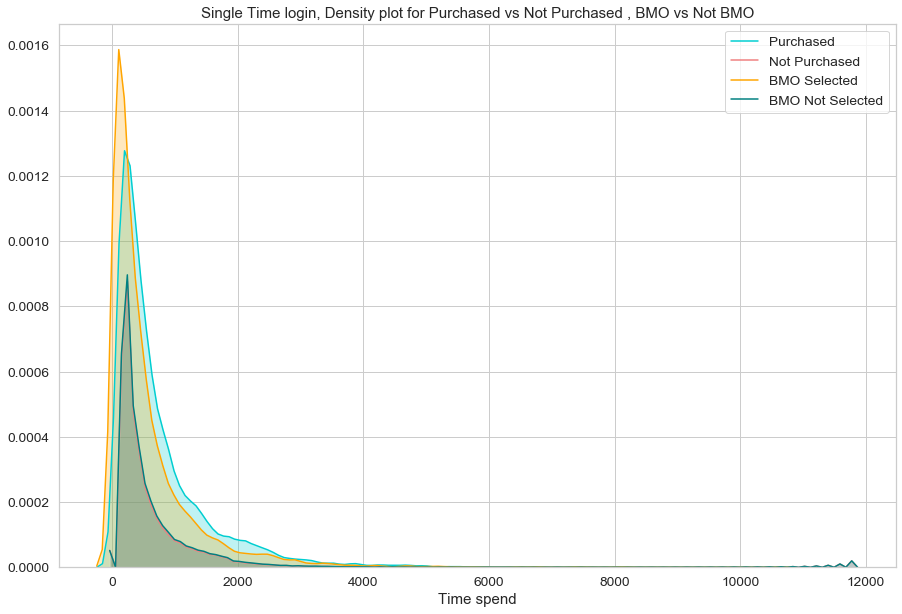

In [48]:
sns.set_style('whitegrid')
plt.figure(figsize=(15,10))
ax = sns.kdeplot(df_single_user['visitorduration'][df_single_user.payment == 1], color='darkturquoise', shade=True)
sns.kdeplot(df_single_user['visitorduration'][df_single_user.payment == 0], color='lightcoral', shade=True)
sns.kdeplot(df_single_user['visitorduration'][df_single_user.bmo == 1], color='orange', shade=True)
sns.kdeplot(df_single_user['visitorduration'][df_single_user.bmo == 0], color='teal', shade=True)
plt.legend(['Purchased','Not Purchased','BMO Selected', 'BMO Not Selected'])
plt.title('Single Time login, Density plot for Purchased vs Not Purchased , BMO vs Not BMO')
ax.set(xlabel='Time spend')
plt.show()

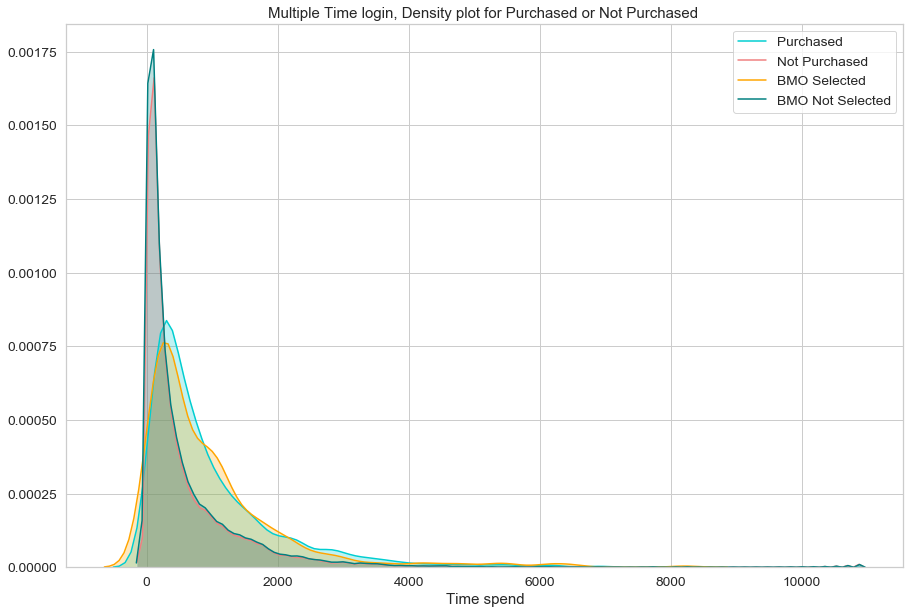

In [49]:
sns.set_style('whitegrid')
plt.figure(figsize=(15,10))
ax = sns.kdeplot(df_multi_user['visitorduration'][df_multi_user.payment == 1], color='darkturquoise', shade=True)
sns.kdeplot(df_multi_user['visitorduration'][df_multi_user.payment == 0], color='lightcoral', shade=True)
sns.kdeplot(df_multi_user['visitorduration'][df_multi_user.bmo == 1], color='orange', shade=True)
sns.kdeplot(df_multi_user['visitorduration'][df_multi_user.bmo == 0], color='teal', shade=True)
plt.legend(['Purchased','Not Purchased','BMO Selected', 'BMO Not Selected'])
plt.title('Multiple Time login, Density plot for Purchased or Not Purchased ')
ax.set(xlabel='Time spend')
plt.show()

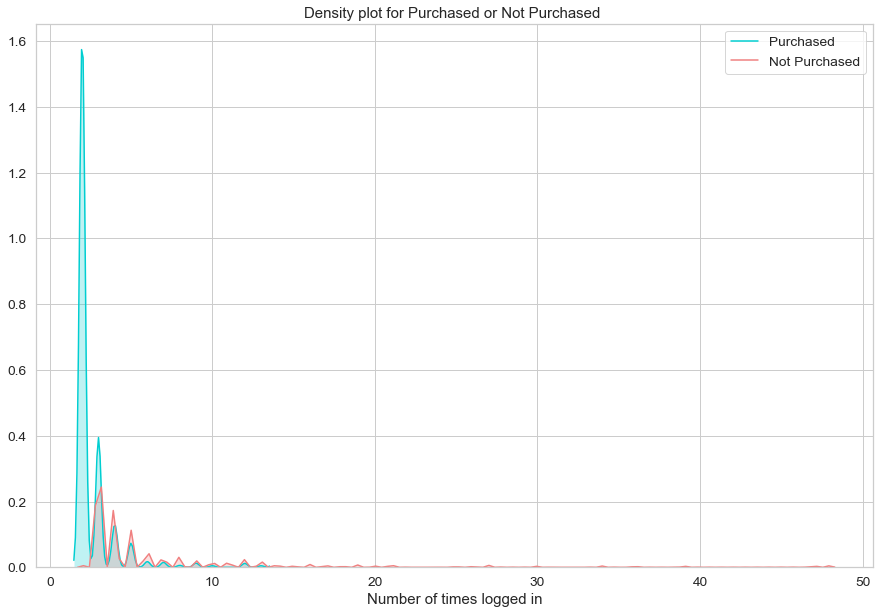

In [50]:
sns.set_style('whitegrid')
plt.figure(figsize=(15,10))
ax = sns.kdeplot(df_multi_user['count'][df_multi_user.payment == 1], color='darkturquoise', shade=True)
sns.kdeplot(df_multi_user['count'][df_multi_user.payment == 0], color='lightcoral', shade=True)
plt.legend(['Purchased','Not Purchased'])
plt.title('Density plot for Purchased or Not Purchased ')
ax.set(xlabel='Number of times logged in')
plt.show()

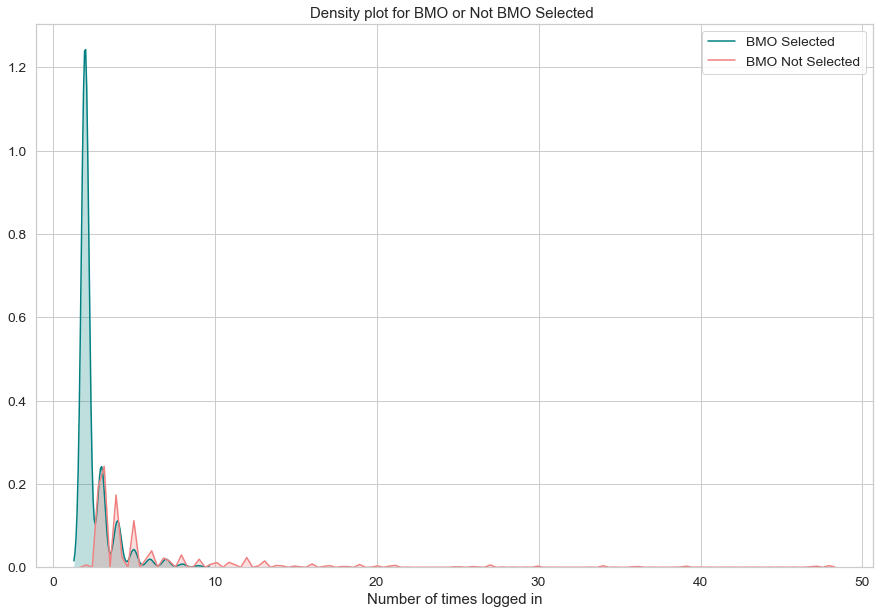

In [51]:
sns.set_style('whitegrid')
plt.figure(figsize=(15,10))
ax = sns.kdeplot(df_multi_user['count'][df_multi_user.bmo == 1], color='teal', shade=True)
sns.kdeplot(df_multi_user['count'][df_multi_user.bmo == 0], color='lightcoral', shade=True)
plt.legend(['BMO Selected','BMO Not Selected'])
plt.title('Density plot for BMO or Not BMO Selected ')
ax.set(xlabel='Number of times logged in')
plt.show()

#### Combining different pages.

In [52]:
df=session_data
df['eventcount'] = df[['eventcountpt', 'eventcountlc']].sum(axis=1)

df["vehicle200"] = df[["vehicle200pt", "vehicle200lc"]].sum(axis = 1)

df["vehicle200convertible"] = df[["vehicle200convertiblept", "vehicle200convertiblelc"]].sum(axis = 1)

df["vehicle300"] = df[["vehicle300pt", "vehicle300lc"]].sum(axis = 1)

df["vehicletowncountry"] = df[["vehicletowncountrypt", "vehicletowncountrylc"]].sum(axis = 1)


vsc = ['vsclanding', 'vscmodels', 'vscgallery', 'vscexterior', 'vscinterior',
   'vscperformance', 'vscsafety', 'vscawards', 'vscspecifications',
   'vscmodelhighlights', 'vscdimensions', 'vscwarranty']
df["vsc"] = df[vsc].sum(axis = 1)


msp = ['msplanding', 'mspgallery', 'mspexterior', 'mspinterior', 'mspperformance',  'mspsafety']
df["msp"] = df[msp].sum(axis = 1)

st_dl = ['stenterzip', 'stenterzipresult', 'stdlhours', 'stdlservices', 'stdldealersites']
df["st_dl"] = df[st_dl].sum(axis = 1)


st_bmo = ['stbmovehicleselector', 'stmodels', 'stcolors', 'stoptions', 'stsummaries']
df["st_bmo"] = df[st_bmo].sum(axis = 1)


st_compare = ["stmodelcompareindex", "stmodelcomparemodelbymodel", "stmodelcomparequickchart", 
                "stmodelcomparegraphsnumbers", "stmodelcomparedetailedchart"]
df["st_compare"] = df[st_compare].sum(axis = 1)

st_form = ['stgaqform', 'stgaqsubmitted', 'stbrochuredownloadform', 'stsignupforupdatessubmit',
           "stbrochuremailform", "stsignupforupdatesform"]
df["st_form"] = df[st_form].sum(axis = 1)


st_sni = ['stsnivehicleselectorresult', 'stsnivin', 'stsnidetails', 'stsnidealers']
df["st_sni"] = df[st_sni].sum(axis = 1)


st_incentive = ['stincentivesbrand', 'stincentivesvehicle']
df["st_incentive"] = df[st_incentive].sum(axis = 1)


st_pay = ['stprecalc', 'stpaymentresults']
df["st_pay"] = df[st_pay].sum(axis = 1)

df.head()

visitorid  visitordate visitormonth  visitoryear  \
0  2DEGHH81B2-4H79-J2G7            6          Aug         2013   
1  2DB42B0569-H5HD-JJBF           13          Jun         2013   
2  2D61CGGJ2C-2F86-43G9            6          Sep         2013   
3  2E19765EF7-AG57-5J72           12          Nov         2013   
4  2DDD5IH5G2-IH15-5I3J           19          Jul         2013   

  visitorstartdayname visitorstarthour  visitorduration  visitorsession  \
0                 Sun         10:59:43               13               1   
1                 Sun         10:22:40               39               1   
2                 Sun         19:05:23                2               2   
3                 Sat         13:03:23               49               1   
4                 Sat         23:30:07              484               1   

      brand devicetype  eventcountpt  eventcountlc   trafficsource  \
0  Chrysler     Mobile             1             4  Other Referral   
1  Chrysler   Computer             4             3     Paid Search   
2  Chrysler   Computer             2             2          Direct   
3  Chrysler   Computer             4             4          Direct   
4  Chrysler   Computer            12            10     Paid Search   

   vehicle200pt  vehicle200lc  vehicle200convertiblept  \
0             0             0                        0   
1             0             0                        0   
2             0             0                        0   
3             0             0                        4   
4             3             2                        0   

   vehicle200convertiblelc  vehicle300pt  vehicle300lc  vehicletowncountrypt  \
0                        0             0             0                     0   
1                        0             4             3                     0   
2                        0             0             0                     0   
3                        4             0             0                     0   
4                        0             3             2                     2   

   vehicletowncountrylc  vsclanding  vscmodels  vscgallery  vscexterior  \
0                     0           0          0           0            0   
1                     0           1          0           0            0   
2                     0           0          0           0            0   
3                     0           0          0           0            0   
4                     3           2          0           0            0   

   vscinterior  vscperformance  vscsafety  vscawards  vscspecifications  \
0            0               0          0          0                  0   
1            0               0          0          0                  0   
2            0               0          0          0                  0   
3            0               0          0          0                  0   
4            0               0          0          0                  0   

   vscmodelhighlights  vscdimensions  vscwarranty  msplanding  mspgallery  \
0                   0              0            0           0           0   
1                   0              0            0           2           0   
2                   0              0            0           0           0   
3                   0              0            0           0           0   
4                   0              0            0           2           0   

   mspexterior  mspinterior  mspperformance  mspsafety  stbmovehicleselector  \
0            0            0               0          0                     0   
1            0            0               0          0                     0   
2            0            0               0          0                     0   
3            0            0               0          0                     0   
4            0            0               0          0                     0   

   stmodels  stcolors  stoptions  stsummaries  stenterzip  stenterzip

In [53]:
 #Just keeping the combined features only
web_pages =df[['vehicle200','vehicle200convertible','vehicle300','vehicletowncountry','vsc','msp','st_dl','st_bmo','st_compare','st_form','st_sni','st_incentive','st_pay']]
web_pages.head()

vehicle200  vehicle200convertible  vehicle300  vehicletowncountry  vsc  \
0           0                      0           0                   0    0   
1           0                      0           7                   0    1   
2           0                      0           0                   0    0   
3           0                      8           0                   0    0   
4           5                      0           5                   5    2   

   msp  st_dl  st_bmo  st_compare  st_form  st_sni  st_incentive  st_pay  
0    0      0       0           0        0       0             0       0  
1    2      0       0           0        0       0             0       0  
2    0      2       0           0        0       0             0       0  
3    0      0       4           0        0       0             0       0  
4    2      0       0           0        0       0             0       0

In [54]:
web_pages[web_pages>0]=1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3530: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



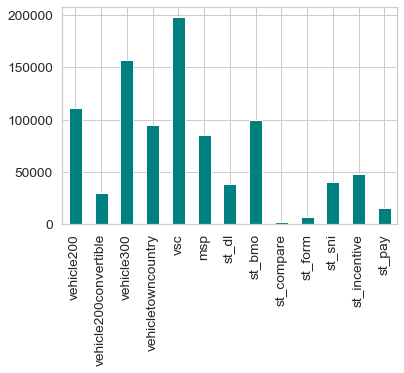

In [55]:
web_pages.sum().plot(kind='bar',color = 'teal')

**Top 3 Shopping tools are: \
    1.BMO\
    2.Incentives\
    3.Search new inventory**

### Model based feature selection:
**This helps us understand which features are contributing towards reaching the target page**

***Taking Payment as target***

In [56]:
#Just keeping the combined features only
X_payment=df[['visitorduration','trafficsource','eventcount','vehicle200','vehicle200convertible','vehicle300','vehicletowncountry','vsc','msp','st_dl','st_bmo','st_compare','st_form','st_sni','st_incentive']]
y_payment=df[['payment']]


In [57]:
#Get Dummy variables for categorical data
X_payment=pd.get_dummies(X_payment,columns=['trafficsource'])
X_payment.head()

visitorduration  eventcount  vehicle200  vehicle200convertible  vehicle300  \
0               13           5           0                      0           0   
1               39           7           0                      0           7   
2                2           4           0                      0           0   
3               49           8           0                      8           0   
4              484          22           5                      0           5   

   vehicletowncountry  vsc  msp  st_dl  st_bmo  st_compare  st_form  st_sni  \
0                   0    0    0      0       0           0        0       0   
1                   0    1    2      0       0           0        0       0   
2                   0    0    0      2       0           0        0       0   
3                   0    0    0      0       4           0        0       0   
4                   5    2    2      0       0           0        0       0   

   st_incentive  trafficsource_Direct  trafficsource_Display  \
0             0                     0                      0   
1             0                     0                      0   
2             0                     1                      0   
3             0                     1                      0   
4             0                     0                      0   

   trafficsource_Email  trafficsource_LLC Group  trafficsource_Natural Search  \
0                    0                        0                             0   
1                    0                        0                             0   
2                    0                        0                             0   
3                    0                        0                             0   
4                    0                        0                             0   

   trafficsource_Other Referral  trafficsource_Paid Search  \
0                             1                          0   
1                             0                          1   
2                             0                          0   
3                             0                          0   
4                             0                          1   

   trafficsource_Social  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0

In [58]:
#split in training and test sets
X_train,X_test,y_train,y_test = train_test_split(X_payment,y_payment,random_state = 0, test_size = 0.3)

In [59]:
# SelectFromModel selects from the supervised Model, the features that has importance  measure more than the threshold.
#We have used median as the threshold to get 50% of the features

select_payment = SelectFromModel(RandomForestClassifier(n_estimators = 30, random_state = 4), threshold="median")

In [60]:
#Fitting the model
select_payment.fit(X_train, y_train)
X_train_l1 = select_payment.transform(X_train)
print("X_train shape: {}".format(X_train.shape))
print("X_train_l1 shape: {}".format(X_train_l1.shape))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\_from_model.py:224: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



X_train shape: (332993, 22)
X_train_l1 shape: (332993, 11)


In [61]:
#Performance
X_test_l1=select_payment.transform(X_test)
score=LogisticRegression().fit(X_train_l1,y_train).score(X_test_l1,y_test)
print("Test Score: {:.3f}".format(score))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Test Score: 0.963


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



**Following are the selected features in decreasing order of feature importance**

In [62]:
features=X_payment.columns
for feature_list_index in select_payment.get_support(indices=True):
    print(features[feature_list_index])

visitorduration
eventcount
vehicle200
vehicle200convertible
vehicle300
vehicletowncountry
vsc
msp
st_bmo
st_sni
st_incentive


***Taking BMO as target***

In [63]:
X_bmo=df[['visitorduration','trafficsource','eventcount','vehicle200','vehicle200convertible','vehicle300','vehicletowncountry','vsc','msp','st_dl','st_pay','st_compare','st_form','st_sni','st_incentive']]
y_bmo=df[['bmo']]

In [64]:
#Create Dummy variables
X_bmo=pd.get_dummies(X_bmo,columns=['trafficsource'])

In [65]:
#split into train and test sets
X_train,X_test,y_train,y_test = train_test_split(X_bmo,y_bmo,random_state = 0, test_size = 0.3)

In [66]:
select_bmo = SelectFromModel(RandomForestClassifier(n_estimators = 60, random_state = 9), threshold="median")

In [67]:
select_bmo.fit(X_train, y_train)
X_train_l1 = select_bmo.transform(X_train)
print("X_train shape: {}".format(X_train.shape))
print("X_train_l1 shape: {}".format(X_train_l1.shape))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\_from_model.py:224: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



X_train shape: (332993, 22)
X_train_l1 shape: (332993, 11)


In [68]:
#Performance
X_test_l1=select_bmo.transform(X_test)
score=LogisticRegression().fit(X_train_l1,y_train).score(X_test_l1,y_test)
print("Test Score: {:.3f}".format(score))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Test Score: 0.988


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



***Top Featurs determining whether a visitor will visit the BMO page or not***

In [69]:
features=X_bmo.columns
for feature_list_index in select_bmo.get_support(indices=True):
    print(features[feature_list_index],)

visitorduration
eventcount
vehicle200
vehicle200convertible
vehicle300
vehicletowncountry
vsc
msp
st_pay
st_sni
st_incentive


### Page importance using a model

In [70]:
X_page=df[['vehicle200','vehicle200convertible','vehicle300','vehicletowncountry','vsc','msp','st_dl','st_bmo','st_compare','st_form','st_sni','st_incentive']]
y_page=df[['payment']]

In [71]:
#Splitting into train and test
X_train,X_test,y_train,y_test = train_test_split(X_page,y_page,random_state = 0, test_size = 0.3)

In [72]:
print(X_page.shape)
print(X_train.shape)
print(X_test.shape)

(475705, 12)
(332993, 12)
(142712, 12)


**Due to high class imbalance, we have implemented SMOTE along with random under sampling.**

In [73]:
over=SMOTE(sampling_strategy = 0.1)
under=RandomUnderSampler(sampling_strategy=0.5)
steps=[('o',over),('u',under)]
pipeline=Pipeline(steps=steps)
X_train,y_train=pipeline.fit_resample(X_train,y_train)

**The following plot shows the distribution of records for the two classes in the target variabe i.e Payment.**

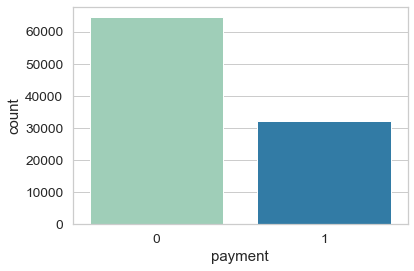

In [74]:
sns.countplot(x='payment',data=y_train,palette='YlGnBu')

In [75]:
#Decision tree model to undersatnd the 
decision_tree_model=tree.DecisionTreeClassifier(max_depth=4)
decision_tree_model.fit(X_train, y_train)#X_train, y_train X, y

DecisionTreeClassifier(max_depth=4)

In [76]:
#X_train: Prediction on the training dataset
y_predict=decision_tree_model.predict(X_test)

In [77]:
#Accuracy score:
accuracy_score(y_test,y_predict)

0.8261183362296093

**Feature importance**

In [78]:
pd.Series(decision_tree_model.feature_importances_, index=X_page.columns).sort_values(ascending=False)

st_bmo                   0.621831
st_sni                   0.204392
vehicletowncountry       0.136452
vehicle200               0.020720
vsc                      0.012703
vehicle300               0.003902
st_incentive             0.000000
st_form                  0.000000
st_compare               0.000000
st_dl                    0.000000
msp                      0.000000
vehicle200convertible    0.000000
dtype: float64

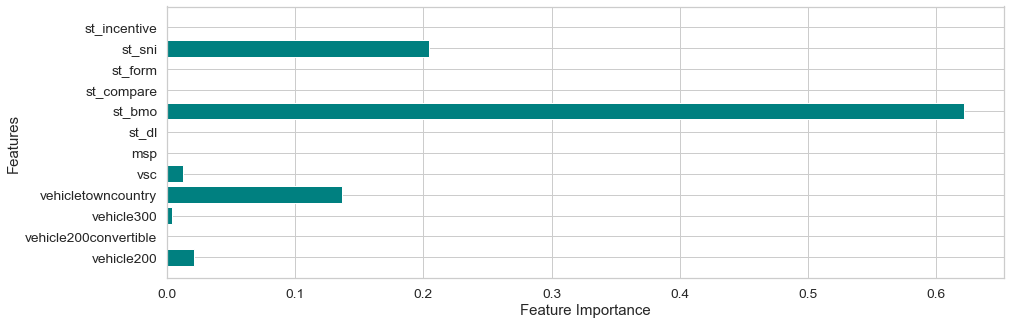

In [79]:
def plot_feature_importance(model,n_features,feature_names):
    plt.figure(figsize=(15,5))
    plt.barh(range(n_features),model.feature_importances_,align='center',color = 'teal')
    plt.yticks(np.arange(n_features),feature_names)
    plt.xlabel("Feature Importance")
    plt.ylabel("Features")
    plt.ylim(-1,n_features)
    
plot_feature_importance(decision_tree_model,X_page.shape[1],X_page.columns)

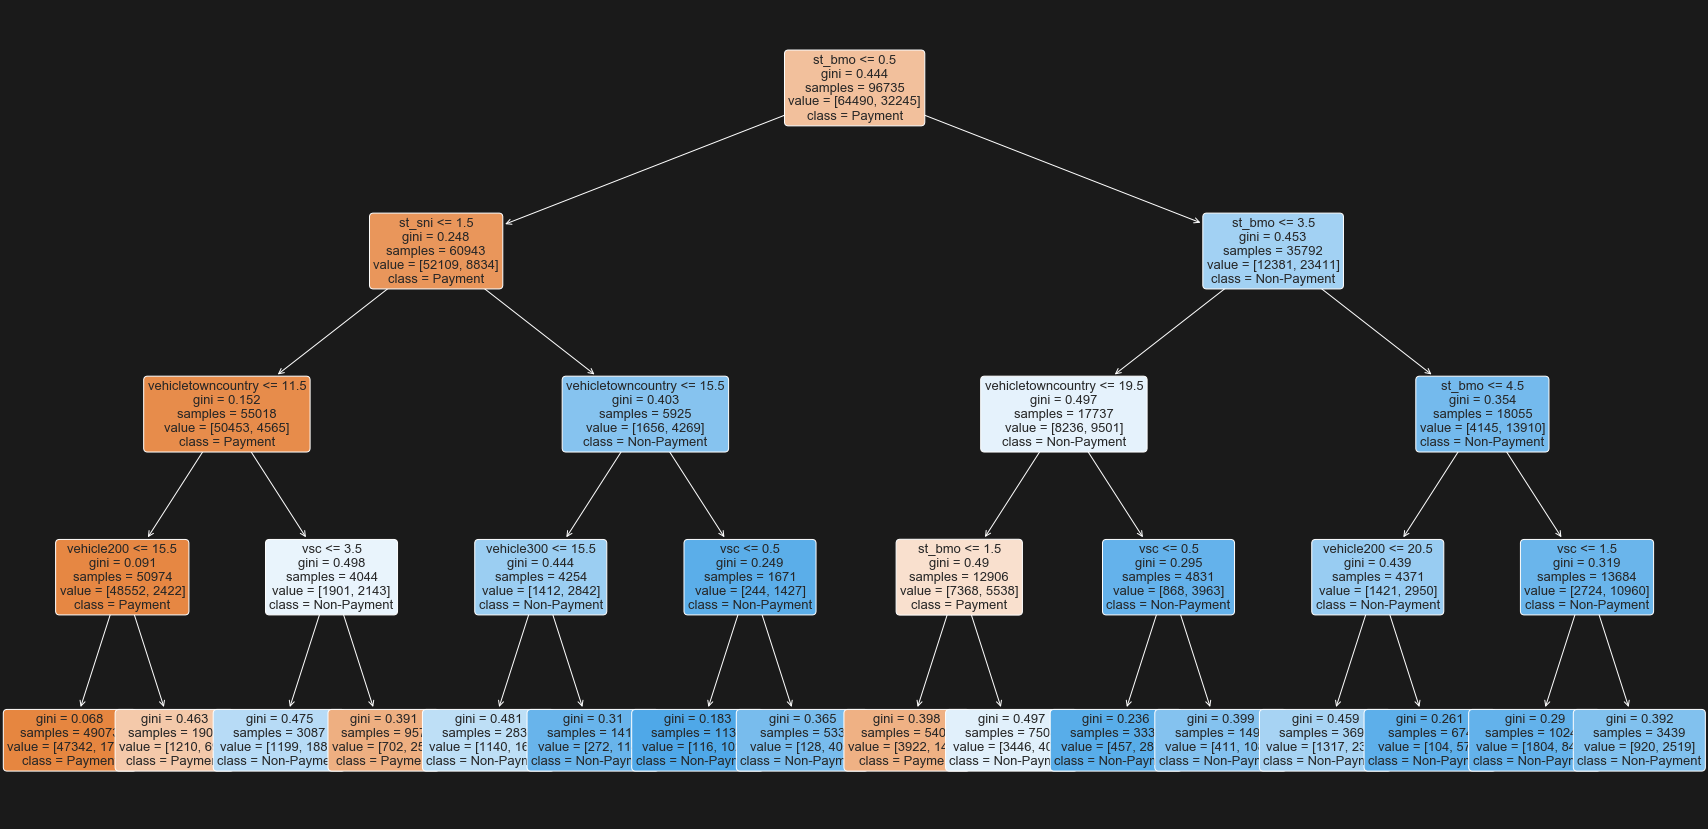

In [80]:
plt.figure(figsize=(30,15),facecolor='k')
a = tree.plot_tree(decision_tree_model, feature_names=X_page.columns, 
                class_names=['Payment','Non-Payment'],
                 filled = True,
                 rounded = True,
                 fontsize=13)


**The following two tables represnt the number of visitors on different page groups.**

**The first one is categorized based on traffic sources**

**The second one is categorized based on device type**

In [81]:
df2 =df[['devicetype','trafficsource','vehicle200','vehicle200convertible','vehicle300','vehicletowncountry','vsc','msp','st_dl','st_bmo','st_compare','st_form','st_sni','st_incentive','st_pay']]
df2.head()

devicetype   trafficsource  vehicle200  vehicle200convertible  vehicle300  \
0     Mobile  Other Referral           0                      0           0   
1   Computer     Paid Search           0                      0           7   
2   Computer          Direct           0                      0           0   
3   Computer          Direct           0                      8           0   
4   Computer     Paid Search           5                      0           5   

   vehicletowncountry  vsc  msp  st_dl  st_bmo  st_compare  st_form  st_sni  \
0                   0    0    0      0       0           0        0       0   
1                   0    1    2      0       0           0        0       0   
2                   0    0    0      2       0           0        0       0   
3                   0    0    0      0       4           0        0       0   
4                   5    2    2      0       0           0        0       0   

   st_incentive  st_pay  
0             0       0  
1             0       0  
2             0       0  
3             0       0  
4             0       0

In [82]:
#df2[web_pages>0]=1
for pages in (df2.loc[:,"vehicle200":"st_pay"].columns):
    df2[pages][df2[pages]>0] = 1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:9114: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3326: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [83]:
df2.head()

devicetype   trafficsource  vehicle200  vehicle200convertible  vehicle300  \
0     Mobile  Other Referral           0                      0           0   
1   Computer     Paid Search           0                      0           1   
2   Computer          Direct           0                      0           0   
3   Computer          Direct           0                      1           0   
4   Computer     Paid Search           1                      0           1   

   vehicletowncountry  vsc  msp  st_dl  st_bmo  st_compare  st_form  st_sni  \
0                   0    0    0      0       0           0        0       0   
1                   0    1    1      0       0           0        0       0   
2                   0    0    0      1       0           0        0       0   
3                   0    0    0      0       1           0        0       0   
4                   1    1    1      0       0           0        0       0   

   st_incentive  st_pay  
0             0       0  
1             0       0  
2             0       0  
3             0       0  
4             0       0

In [84]:
df2[web_pages>0]

devicetype trafficsource  vehicle200  vehicle200convertible  \
0             NaN           NaN         NaN                    NaN   
1             NaN           NaN         NaN                    NaN   
2             NaN           NaN         NaN                    NaN   
3             NaN           NaN         NaN                    1.0   
4             NaN           NaN         1.0                    NaN   
...           ...           ...         ...                    ...   
483499        NaN           NaN         1.0                    NaN   
483500        NaN           NaN         NaN                    NaN   
483501        NaN           NaN         NaN                    NaN   
483502        NaN           NaN         NaN                    NaN   
483503        NaN           NaN         NaN                    NaN   

        vehicle300  vehicletowncountry  vsc  msp  st_dl  st_bmo  st_compare  \
0              NaN                 NaN  NaN  NaN    NaN     NaN         NaN   
1              1.0                 NaN  1.0  1.0    NaN     NaN         NaN   
2              NaN                 NaN  NaN  NaN    1.0     NaN         NaN   
3              NaN                 NaN  NaN  NaN    NaN     1.0         NaN   
4              1.0                 1.0  1.0  1.0    NaN     NaN         NaN   
...            ...                 ...  ...  ...    ...     ...         ...   
483499         NaN                 NaN  1.0  1.0    NaN     NaN         NaN   
483500         NaN                 1.0  NaN  NaN    NaN     NaN         NaN   
483501         NaN                 NaN  NaN  NaN    NaN     NaN         NaN   
483502         1.0                 NaN  1.0  1.0    NaN     1.0         NaN   
483503         1.0                 NaN  NaN  NaN    NaN     NaN         NaN   

        st_form  st_sni  st_incentive  st_pay  
0           NaN     NaN           NaN     NaN  
1           NaN     NaN           NaN     NaN  
2           NaN     NaN           NaN     NaN  
3           NaN     NaN           NaN     NaN  
4           NaN     NaN           NaN     NaN  
...         ...     ...           ...     ...  
483499      NaN     NaN           NaN     NaN  
483500      NaN     NaN           NaN     NaN  
483501      NaN     NaN           NaN     NaN  
483502      NaN     NaN           NaN     NaN  
483503      NaN     NaN           1.0     NaN  

[475705 rows x 15 columns]

In [85]:
#df_multiuser_user[(df_multiuser_user.stpaymentresults >0)] visitormonth VisitDateTime
marketing_funnel_pivot = df.groupby(['trafficsource'])['vehicle200',
'vehicle200convertible',
'vehicle300',
'vehicletowncountry',
'vsc',
'msp',
'st_dl',
'st_pay',
'st_compare',
'st_form',
'st_bmo',
'st_sni',
'st_incentive'].apply(lambda x: x.astype(int).sum())

cm = sns.light_palette('teal', as_cmap=True)
marketing_funnel_pivot.style.background_gradient(cmap=cm).set_table_styles([{'selector':'th','props':[('border','4px solid #7a7')]}])

In [86]:
marketing_funnel_pivot1 = df.groupby(['devicetype'])[
'vehicle300',
'vehicletowncountry',
'vehicle200',
'vsc',
'vehicle200convertible',
'msp',
'st_incentive',
'st_sni',
'st_dl',
'st_pay',
#'st_form',
#'st_compare'

].apply(lambda x: x.astype(int).sum())

cm = sns.light_palette('teal', as_cmap=True)
marketing_funnel_pivot1.style.background_gradient(cmap=cm).set_table_styles([{'selector':'th','props':[('border','4px solid #7a7')]}])

In [87]:
#Code to present the funnel chart
data = dict(
        number=list(marketing_funnel_pivot1.iloc[0]),
        stage=list(marketing_funnel_pivot1.columns))
fig=px.funnel(data, x='number',y='stage')
fig.show()

**Tried the decision tree model with after concerting all the predictors to 0 and 1**

In [88]:
# Converting all the features to 0 and 1 and then fit the model
X_train[X_train>0]=1
X_test[X_test>0]=1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3530: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [89]:
#Decision tree model to undersatnd the 
decision_tree_model=tree.DecisionTreeClassifier(max_depth=4)
decision_tree_model.fit(X_train, y_train)#X_train, y_train X, y

DecisionTreeClassifier(max_depth=4)

In [90]:
#X_train: Prediction on the training dataset
y_predict=decision_tree_model.predict(X_test)

In [91]:
#Accuracy score:
accuracy_score(y_test,y_predict)

0.771189528561018

In [92]:
pd.Series(decision_tree_model.feature_importances_, index=X_page.columns).sort_values(ascending=False)

st_bmo                   0.682100
st_sni                   0.261476
vehicletowncountry       0.033845
st_incentive             0.012543
vsc                      0.004763
vehicle200               0.003378
st_dl                    0.001267
msp                      0.000434
st_form                  0.000194
st_compare               0.000000
vehicle300               0.000000
vehicle200convertible    0.000000
dtype: float64

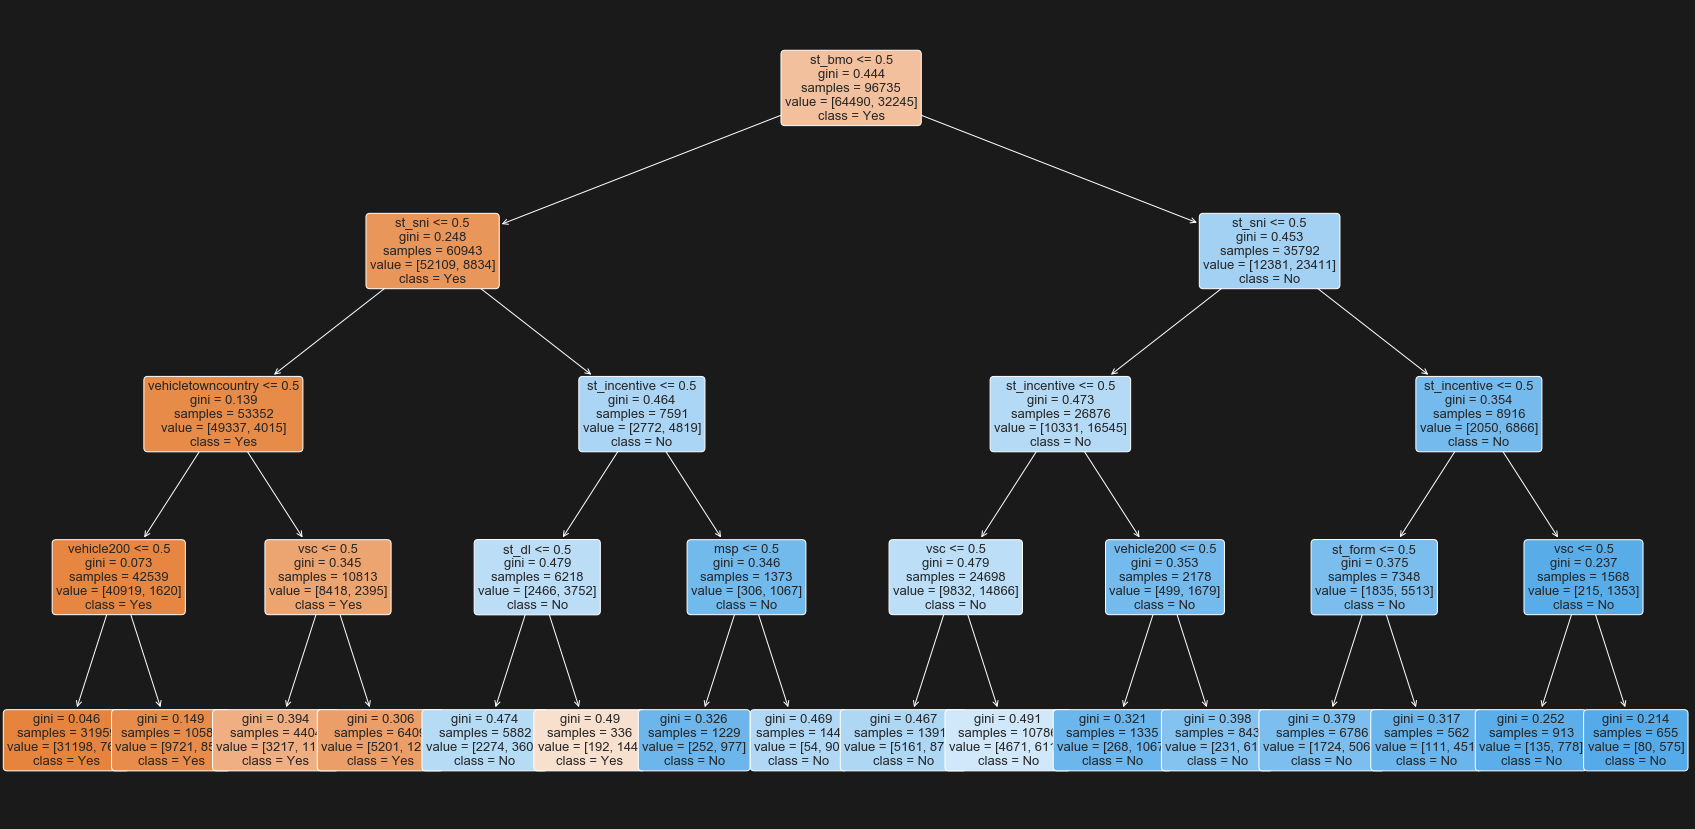

In [93]:
plt.figure(figsize=(30,15),facecolor='k')
a = plot_tree(decision_tree_model, feature_names=X_page.columns, 
                class_names=["Yes","No"],
                 filled = True,
                 rounded = True,
                 fontsize=13)

**Eventhough Incentives is the second most used shopping tools, it does not seem to be so attractive and hence is not hepling us predict the conversion**

In [94]:
#Conversion percentage:
print("The conversion percentage : ", (web_pages.query("st_pay ==1").shape[0]/web_pages.shape[0])*100)

The conversion percentage :  3.215017710555912


In [95]:
#total visitors who checked payment result
web_pages.query("st_pay ==1").shape[0]

15294

In [96]:
#Did not visit BMO page but visited Payment result page.
#Visitors who are interested in payment result and not BMO
web_pages.query("st_bmo == 0").query("st_pay ==1").shape[0]

4135

In [97]:
#Did visited BMO page but did not check Payment result page.
web_pages.query("st_bmo == 1").query("st_pay ==0").shape[0]

88530

In [98]:
#Did not visit BMO page but visited Payment result page.
web_pages.query("st_sni == 0").query("st_pay ==1").shape[0]

9465

<b>IPBA - Batch 11, April 2020</b> <br>
<b>Team members:</b><br>
Anjan Singha<br>
Krishnamoorthy Srinivasan<br>
Sabyasachi Das<br>
Shagun Sood<br>
Varun Kuzhikattil<br>
Yash Mangla<br>